# Connect ends of bags for xLASM grain size data where no bag missing and interpolate data
***
* Author: Yannick E. Heiser
* Email:  wfg813@alumni.ku.dk
* Last Update:   1st of May 2023
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit 
from ExternalFunctions import Chi2Regression
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.axisbelow'] = True
import sys
import glob
import os
from tkinter import Tcl
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.signal import welch
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.ticker as ticker
!{sys.executable} -m pip install xlrd

### 1. Load grain size data from csv

In [2]:
def read_csv(path):
    """
    read in csv files with grain size data and put it in dict of dataframes
    --------------------------------------
    param: (str) path: path of csv files
    """
    df = {}
    if path != None:
        os.chdir(path)    
    files = glob.glob("*.csv")
    files = Tcl().call('lsort', '-dict', files) #sort csv files after name
    for i in range(len(files)):
        file = files[i]
        bag = file[:-4]
        df[bag] = pd.read_csv(file)
    return df

In [3]:
resolution_mm = {"2": 2}
df_sizes = {}
file_path = "/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/"

for key in resolution_mm.keys():
    print(key)
    path = file_path + "{}mm_intervall".format(resolution_mm[key])
    df_sizes[key] = read_csv(path)

2


In [4]:
df_sizes[list(df_sizes.keys())[0]]["nmx3642b"].head()

,crop_image,depth[m],equivalent_diameter[px],grain_size[px],grain_size_err[px]
0,0,2002.804045,185.808933,8.335600e+05,0
1,0,2002.805045,248.307759,1.483085e+06,0
2,0,2002.806045,277.977147,1.941228e+06,0
3,0,2002.807045,296.058057,2.161746e+06,0
4,0,2002.808045,391.027804,3.790075e+06,0


### 2. Interpolate ends of bags with next one and missing data

In [5]:
for res in list(df_sizes.keys()):
    bags = list(df_sizes[res].keys())
    for i in range(len(bags)-1):
        if df_sizes[res][bags[i]]["depth[m]"].iloc[-5]>df_sizes[res][bags[i+1]]["depth[m]"].iloc[2]:
            print(i, bags[i])      

0 nmx3642b


In [12]:
# Plot of grain sizes with different interval resolutions
bags = list(df_sizes[list(df_sizes.keys())[0]].keys())
for i in range(len(bags)-1):  
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(df_sizes[list(df_sizes.keys())[0]][bags[i]]["depth[m]"].iloc[2:-4], df_sizes[list(df_sizes.keys())[0]][bags[i]]["grain_size[px]"].iloc[2:-4], "-",label=bags[i])
    ax.plot(df_sizes[list(df_sizes.keys())[0]][bags[i+1]]["depth[m]"].iloc[2:-4], df_sizes[list(df_sizes.keys())[0]][bags[i+1]]["grain_size[px]"].iloc[2:-4], "-",label=bags[i+1])
    ax.set_xlabel('Depth top (m)')
    ax.set_ylabel('grain size [px]')
    ax.legend()
    fig.tight_layout()
    fig.show()
    plt.close()

In [13]:
# Create DF containing all data over depth but cutting 2mm at beginning and 4mm at end of each bag
column_names = list(df_sizes[list(df_sizes.keys())[0]]["nmx3642b"].columns)
column_names.append("bag")
df_sizes_all = {}

for res in df_sizes.keys():
    df_sizes_all[res] = pd.DataFrame(columns=column_names)
    for bag in df_sizes[res].keys():
        df_sizes_copy = df_sizes[res][bag].iloc[2:-4].copy()
        df_sizes_copy["bag"] = bag
        df_sizes_all[res] = pd.concat([df_sizes_all[res],df_sizes_copy],ignore_index=True)
    df_sizes_all[res] = df_sizes_all[res].sort_values(by=["depth[m]"])
    df_sizes_all[res] = df_sizes_all[res].reset_index(drop=True)

In [53]:
# Use mean if bags overlap
df_sizes_all_overlap = {}
for res in list(df_sizes_all.keys()):
    print(res)
    df_sizes_all_overlap[res] = df_sizes_all[res].copy()
    for i in range(len(df_sizes_all_overlap[res])-10):
        if abs(df_sizes_all_overlap[res]["depth[m]"].iloc[i+1]-df_sizes_all_overlap[res]["depth[m]"].iloc[i])<0.0005:
            print(i,df_sizes_all_overlap[res]["depth[m]"].iloc[i],df_sizes_all_overlap[res]["bag"].iloc[i])
            df_sizes_all_overlap[res].loc[i+0.5] = np.NaN,np.mean(df_sizes_all_overlap[res]["depth[m]"].iloc[i:i+2]),np.mean(df_sizes_all_overlap[res]["equivalent_diameter[px]"].iloc[i:i+2]),np.mean(df_sizes_all_overlap[res]["grain_size[px]"].iloc[i:i+2]),np.mean(df_sizes_all_overlap[res]["grain_size_err[px]"].iloc[i:i+2]),np.NaN
            df_sizes_all_overlap[res] = df_sizes_all_overlap[res].drop(index=[i,i+1])
            df_sizes_all_overlap[res] = df_sizes_all_overlap[res].sort_index().reset_index(drop=True)

2


In [55]:
for res in df_sizes_all_overlap.keys():
    nan_idx = np.where(np.isnan(df_sizes_all_overlap["2"]["grain_size[px]"]))[0]
    print("NaN values at: ",nan_idx)
    df_sizes_all_overlap[res] = df_sizes_all_overlap[res].drop(nan_idx)
    print("Remaining NaN at: ",np.where(np.isnan(df_sizes_all_overlap[res]["grain_size[px]"])))

NaN values at:  []
Remaining NaN at:  (array([], dtype=int64),)


In [56]:
# Interpolate missing data except if whole bag is missing and make all data equidistant

df_sizes_all_interp = {}
for res in df_sizes_all_overlap.keys():
    print(res)
    # bags 3642-3647
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3642c"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3647b"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    # make equidistant dataset 
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp[res] = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp[res]["depth[m]"] = depth_new
    df_sizes_all_interp[res]["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp[res]["grain_size[px]"] = area_new
    
    # bags 3649-3653
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3649c"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3653b"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3655-3659
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3655c"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3659b"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3661-3665
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3661b"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3665b"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3667-3671
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3667b"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3671b"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3673-3674
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3673c"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3674c"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3676-3677
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3676c"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3677d"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3680-3682
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3680b"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3682c"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)
    
    # bags 3684-3686
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3684b"]
    depth_min = round(df_sizes_all_interp_slic["depth[m]"].iloc[0],3)
    df_sizes_all_interp_slic = df_sizes_all_overlap[res][df_sizes_all_overlap[res]["bag"]=="nmx3686c"]
    depth_max = round(df_sizes_all_interp_slic["depth[m]"].iloc[-1],3)
    
    depth_new = np.arange(depth_min,depth_max,0.001)
    cs_area = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["grain_size[px]"])
    cs_diam = PchipInterpolator(df_sizes_all_overlap[res]["depth[m]"], df_sizes_all_overlap[res]["equivalent_diameter[px]"])
    area_new = cs_area(depth_new)
    diam_new = cs_diam(depth_new)
    df_sizes_all_interp_new = pd.DataFrame(columns=column_names[1:-2])
    df_sizes_all_interp_new["depth[m]"] = depth_new
    df_sizes_all_interp_new["equivalent_diameter[px]"] = diam_new
    df_sizes_all_interp_new["grain_size[px]"] = area_new
    df_sizes_all_interp[res] = pd.concat([df_sizes_all_interp[res],df_sizes_all_interp_new],ignore_index=True)

2


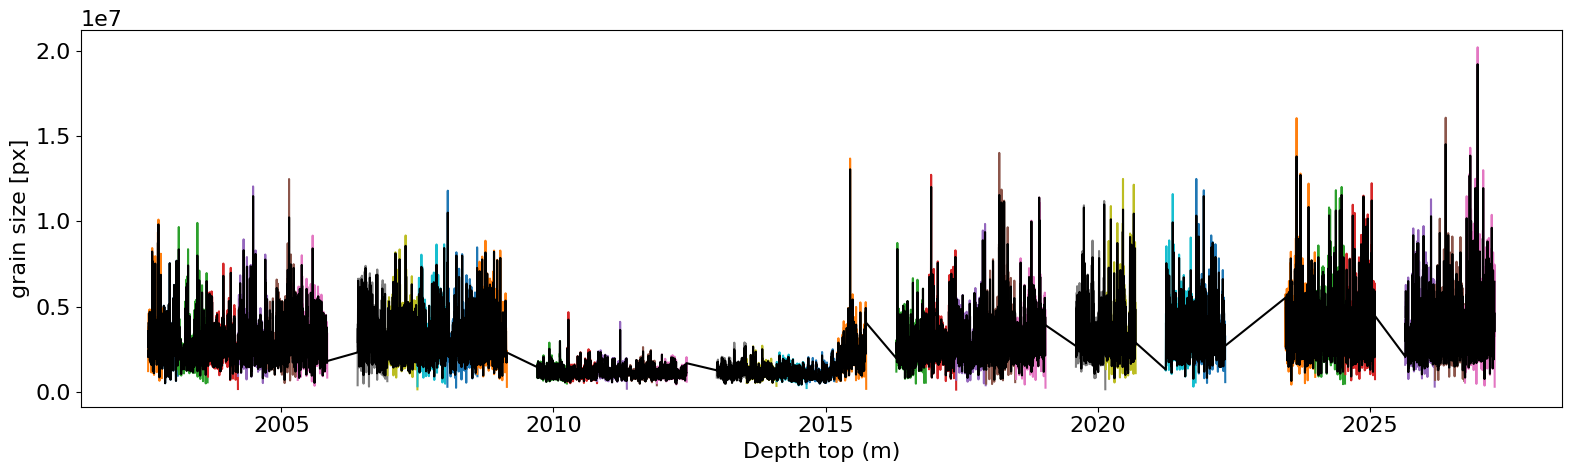

In [57]:
fig, ax = plt.subplots(figsize=(16, 5))
[(ax.plot(df_sizes[list(df_sizes.keys())[0]][bag]["depth[m]"], df_sizes[list(df_sizes.keys())[0]][bag]["grain_size[px]"], "-")) for bag in df_sizes[list(df_sizes.keys())[0]].keys()]
ax.plot(df_sizes_all_interp[list(df_sizes.keys())[0]]["depth[m]"],df_sizes_all_interp[list(df_sizes.keys())[0]]["grain_size[px]"],color="black")
ax.set_xlabel('Depth top (m)')
ax.set_ylabel('grain size [px]')
fig.tight_layout()
fig.show()

In [58]:
# save data as csv
for res in df_sizes_all_interp.keys():
    df_sizes_all_interp[res].to_csv("/home/jovyan/work/PICE/ResearchGroups/Stratigraphy/Yannick 2022/Data_csv/grain_sizes_depth/grain_data_interp_{}mm.csv".format(res),index=False)

['8.8']